In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from DataLoader import *
import datetime
import random
import warnings
from BehaviourFeatureExtractor import *
from BehaviourAnnotation import *
from VocalFeatureExtractor import *
from colour import Color
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import copy
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

# 0. Classes and directories #

In [2]:
config_path = "config.json"
data_dir = "data/"
DL = DataLoader(data_dir, path_to_config_file="config.json")
BA = BehaviourAnnotator(config_path)
BF = BehaviourFeatureExtractor("config.json")
VF = VocalFeatureExtractor("config.json")

In [3]:
processed_data_dir = "processed_data"
annotated_data_dir = "annotated_resolved_data"
transition_path_export_dir = "transition_paths"
export_csv_dir = "annotated_cleaned_resolved_data"
# plots
plot_dir = "full_cleaned_resolved_annotation_plots"


# 1. Data loading #

In [4]:
# load processed annotated data into a dictionary
mouse_ids = [mouse_id for mouse_id in os.listdir(annotated_data_dir) if os.path.isdir(os.path.join(annotated_data_dir, mouse_id)) and (mouse_id.startswith("M") or mouse_id.startswith("V"))]
days = [f"d{i}" for i in range(1, 7)]
processed_and_annotated_data = load_processed_data(annotated_data_dir, mouse_ids, days)

# 2. Plotting #

In [19]:
table = processed_and_annotated_data['MBQ0231R']['d1']["trials"][1]["dlc_data"]["behavior_annotation"].value_counts()
key = "retrieval"
# access a key of the table
try:
    table[key]
except KeyError:
    for key in table.keys():
        print(key)

in_nest
none
walking
approach
still
active_interaction
crouching


In [82]:
# plotting helper functions

def get_trial_information(experiment_data, mouse_ids, BA, categories = ["Mother", "Virgin"], sessions = ["d1", "d2", "d3", "d4", "d5", "d6"]):
    """ Takes a list of categories and sessions and returns a dictionary of trial information """

    trial_information = {"Mother": {f"d{i}": {k:[] for k in BA.states} for i in range(1,7)},
                         "Virgin": {f"d{i}": {k:[] for k in BA.states} for i in range(1,7)}}

    for mouse_id in mouse_ids:
        category = "Mother" if mouse_id.startswith("M") else "Virgin"
        for session in sessions:

            trials_dlc = [v["dlc_data"]["behavior_annotation"] for k,v in experiment_data[mouse_id][session]["trials"].items()]
            tables = [t.value_counts() for t in trials_dlc]

            for table in tables: # iterate through state count of each table/trial
                for key in BA.states:
                    if key in table.keys():
                        if key in BA.single_event_states:
                            trial_information[category][session][key] += [table[key]]
                        elif key in BA.states:
                            trial_information[category][session][key] += [table[key] / BA.frame_rate]
                    else:
                        trial_information[category][session][key] += [0]


                # for key in table.keys():
                #     if key in BA.single_event_states:
                #         trial_information[category][session][key] += [table[key]] # add the event count 
                #     elif key in BA.states:
                #         trial_information[category][session][key] += [table[key] / BA.frame_rate] # add time spent on given state

    return trial_information

def plot_durations(trial_information, behaviors_to_plot, BA, ax=None):
    """
    Plot behavior durations/counts across sessions for Mother and Virgin mice.
    
    Args:
        trial_information: Dictionary containing behavior data
        behaviors_to_plot: List of behaviors to include in plot
        BA: BehaviorAnnotator object to check single_event_states
        ax: Optional matplotlib axis
    """
    # Map behavior names to readable descriptions
    behavior_labels = {
        "approach": "Approach",
        "walking": "Walking",
        "still": "Still",
        "in_nest": "In Nest",
        "drop": "Total drop Events",
        "pickup": "Total pick-up Events",
        "active_interaction": "Active Interaction",
        "crouching": "Crouching"
    }
    
    # Use BehaviourAnnotator's color scheme
    behavior_colors = {
        "approach": "green",
        "walking": "yellow",
        "still": "gray",
        "in_nest": "cyan",
        "drop": "crimson",
        "pickup": "magenta",
        "active_interaction": "dodgerblue",
        "crouching": "red"
    }
    
    # Create figure if no axis provided
    if ax is None:
        fig, axs = plt.subplots(2, 6, figsize=(20, 8))
    else:
        axs = ax.reshape(2, 6)
    
    categories = ["Mother", "Virgin"]
    sessions = [f"d{i}" for i in range(1, 7)]
    
    # Track max values for y-axis normalization
    max_duration = 0
    max_count = 0
    
    # First pass to find max values
    for category in categories:
        for session in sessions:
            for behavior in behaviors_to_plot:
                if behavior in trial_information[category][session]:
                    values = trial_information[category][session][behavior]
                    if behavior in BA.single_event_states:
                        max_count = max(max_count, np.mean(values))
                    else:
                        max_duration = max(max_duration, np.mean(values) + np.std(values))
    
    # Add 10% padding to max values
    max_duration *= 0.8
    max_count *= 0.5
    
    # Second pass to create plots
    for cat_idx, category in enumerate(categories):
        for ses_idx, session in enumerate(sessions):
            data_to_plot = []
            errors = []
            labels = []
            colors = []
            
            for behavior in behaviors_to_plot:
                if behavior in trial_information[category][session]:

                    # if behavior in BA.single_event_states:
                    #     values = trial_information[category][session][behavior]
                    #     mean_val = np.sum(values)                        
                    #     data_to_plot.append(mean_val)
                    #     errors.append(0)
                    #     labels.append(behavior_labels[behavior])
                    #     colors.append(behavior_colors[behavior])
                    # else:
                    values = trial_information[category][session][behavior]
                    mean_val = np.mean(values)
                    sem_val = np.std(values) / np.sqrt(len(values))
                    
                    data_to_plot.append(mean_val)
                    errors.append(sem_val)
                    labels.append(behavior_labels[behavior])
                    colors.append(behavior_colors[behavior])
                       
            
            # Create bar plot
            x = np.arange(len(data_to_plot))
            bars = axs[cat_idx, ses_idx].bar(x, data_to_plot, yerr=errors, 
                                           color=colors, alpha=0.7)
            
            # Set consistent y-axis limits based on behavior type
            
            axs[cat_idx, ses_idx].set_ylim(0, max_duration)
            # set y label to max count
            axs[cat_idx, ses_idx].set_ylabel("Average duration per trial (s)")
            
            # Customize plot
            axs[cat_idx, ses_idx].set_xticks(x)
            axs[cat_idx, ses_idx].set_xticklabels(labels, rotation=45, ha='right')
            
            # Add title
            axs[cat_idx, ses_idx].set_title(f"{category} - {session}")
            
            # Add y-label only to leftmost plots
            # if ses_idx == 0:
            #     ylabel = "Count" if category == "Virgin" else "Time (s)"
            #     axs[cat_idx, ses_idx].set_ylabel(ylabel)
            
            # Adjust layout for readability
            plt.setp(axs[cat_idx, ses_idx].xaxis.get_majorticklabels(), 
                    rotation=45, ha='right')
    
    plt.tight_layout()
    return axs

In [79]:
trial_information = get_trial_information(processed_and_annotated_data, mouse_ids, BA)

In [86]:
trial_information["Virgin"]["d4"]["crouching"]

[0,
 1.8666666666666667,
 0.5333333333333333,
 0,
 0.16666666666666666,
 1.4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

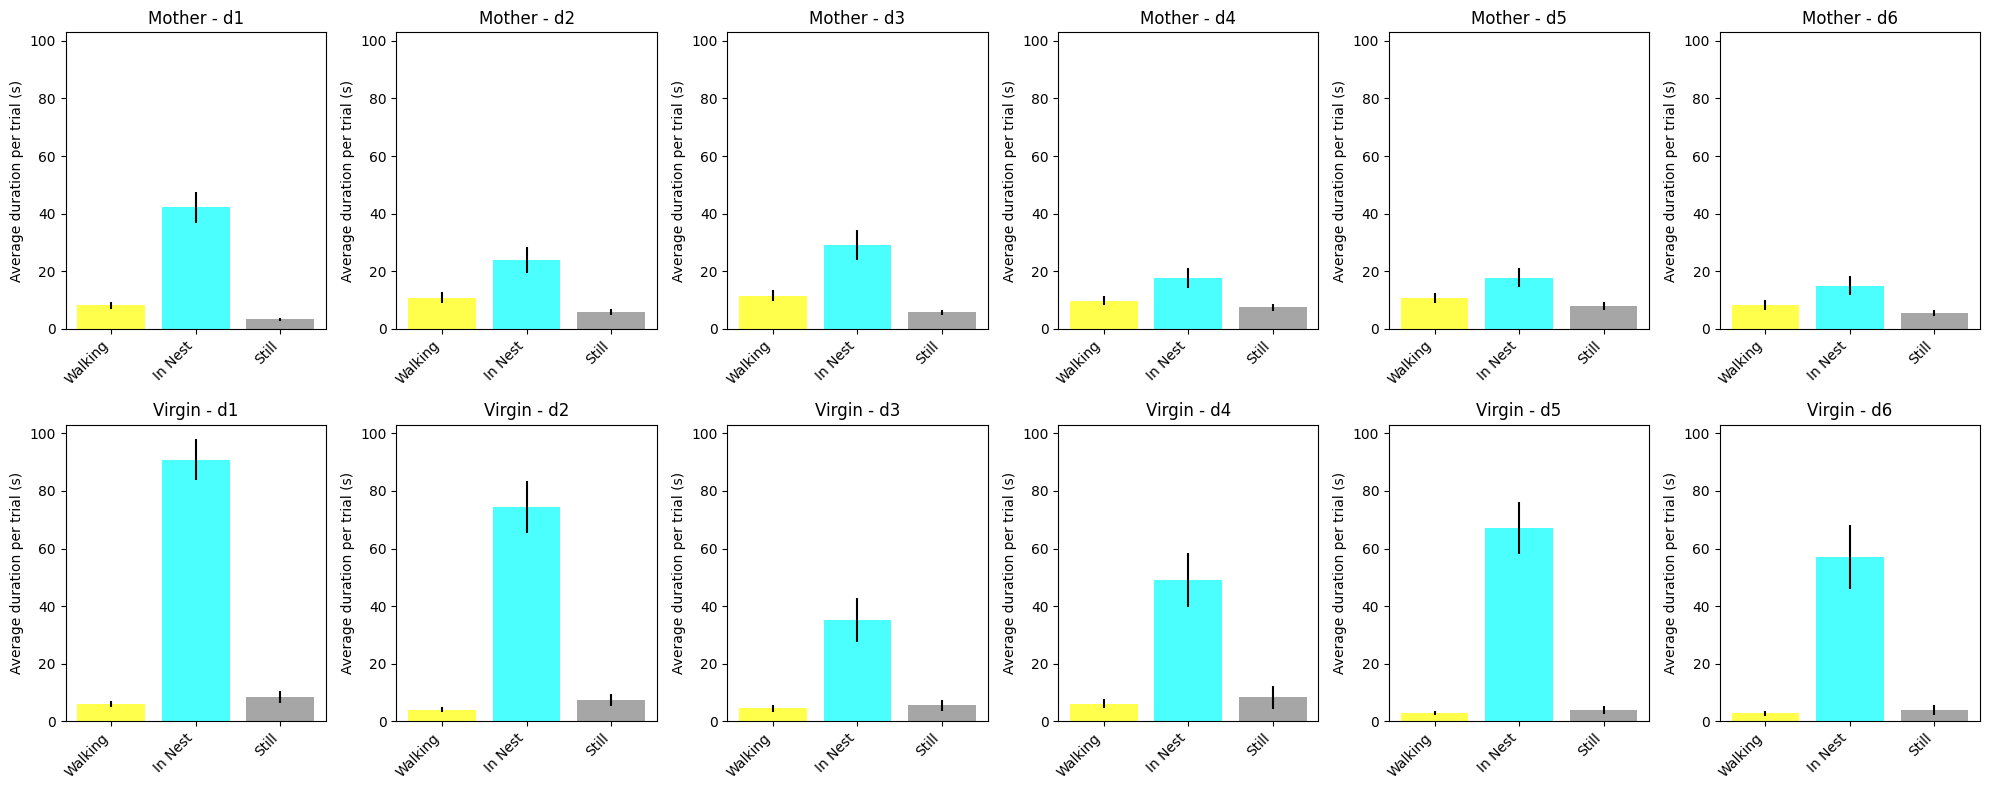

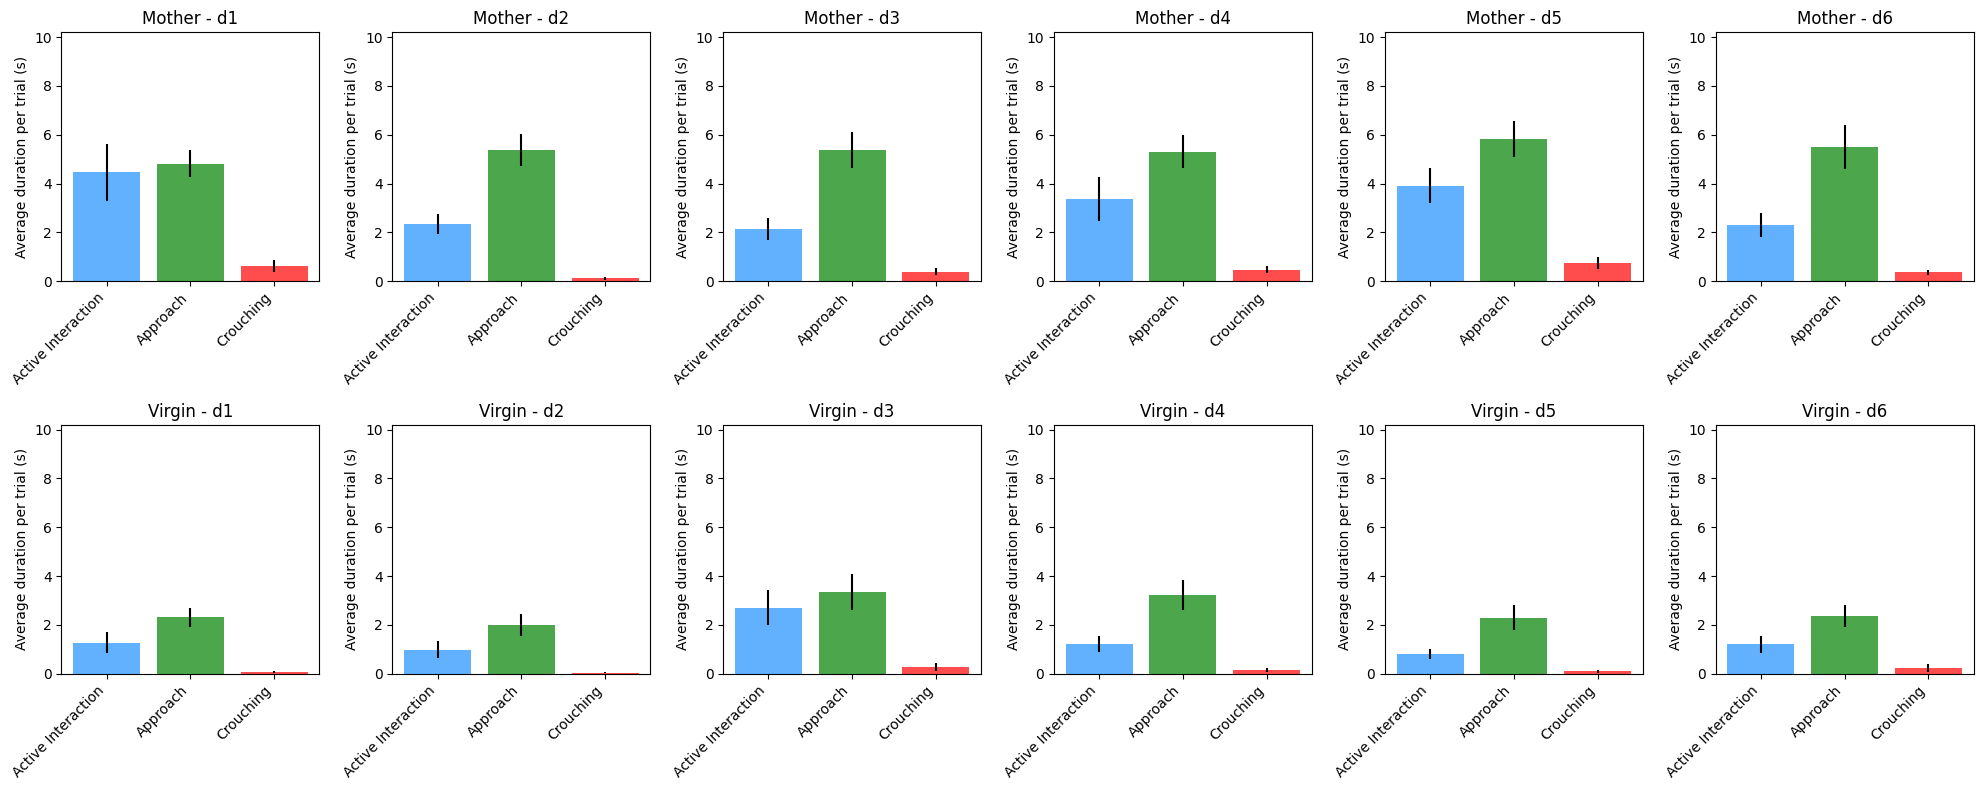

In [83]:
behaviors_to_plot = ["walking", "in_nest", "still"]
plot_durations(trial_information, behaviors_to_plot, BA)
plt.show()

behaviors_to_plot = [ "active_interaction", "approach", "crouching"]
plot_durations(trial_information, behaviors_to_plot, BA)
plt.show()

In [ ]:
# Create a figure with 2 rows and 6 columns

# Get list of categories and days
categories = list(dict_transition_matrices.keys())
days = list(dict_transition_matrices[categories[0]].keys())

######    Individual plots    #######
for category in categories:
    for day in days:
        if day in dict_transition_matrices[category]:
            BA.plot_transition_graph(dict_transition_matrices[category][day], 
                                title=f"{category} - session {day}", ax=None)
        else:
            plt.title(f"{category} - session {day}\n(No data)")

fig, axs = plt.subplots(2, 6, figsize=(50, 15))

#####    Plot each graph on a grid    #######
for i, category in enumerate(categories):
    for j, day in enumerate(days):
        
        axs[i, j].clear()
        axs[i, j].axis('off')

        if day in dict_transition_matrices[category]:
            BA.plot_transition_graph(dict_transition_matrices[category][day],title=f"{category} - session {day}", ax=axs[i,j])

plt.tight_layout()
plt.show()